# ML for NLP

We will use the News Aggregator Dataset provided by Fabio Gasparetti. Download and unpack it. Create a `data` folder and place the unpacked files there.

# Data Preprocessing

In [6]:
import pandas as pd
import numpy as np

In [7]:
filename = "./data/newsCorpora.csv"
names = ["id", "title", "url", "publisher", "category", "story", "hostname", "timestamp"]
df = pd.read_csv(filename, sep='\t', names=names)

In [8]:
publishers = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
fdf = df[df.publisher.isin(publishers)]

In [9]:
# Shuffle: https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
from sklearn.utils import shuffle

sdf = shuffle(fdf)
ratio_1 = int(len(sdf) / 10 * 8)
ratio_2 = int(len(sdf) / 10 * 9)

In [10]:
training = sdf[:ratio_1]
validation = sdf[ratio_1:ratio_2]
test = sdf[ratio_2:]
print("{} : {} : {}".format(len(training), len(validation), len(test)))
print("{} : {} : {}".format(len(training) / len(sdf), len(validation) / len(sdf), len(test) / len(sdf)))

10672 : 1334 : 1334
0.8 : 0.1 : 0.1


In [11]:
tr_filename = "./data/train.txt"
va_filename = "./data/valid.txt"
te_filename = "./data/test.txt"

training.to_csv(tr_filename, sep="\t", header=False, index=False)
validation.to_csv(va_filename, sep="\t", header=False, index=False)
test.to_csv(te_filename, sep="\t", header=False, index=False)

# Feature Extraction

* https://scikit-learn.org/stable/modules/feature_extraction.html

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [13]:
tr = vectorizer.fit_transform(training.title)
va = vectorizer.transform(validation.title)
te = vectorizer.transform(test.title)

In [116]:
feature_names = vectorizer.get_feature_names()

# Training and Prediction

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [14]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(tr, training.category)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
tr_pred = clf.predict(tr)
va_pred = clf.predict(va)
te_pred = clf.predict(te)

# Accuracy
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
training_accuracy = accuracy_score(training.category, tr_pred)
validation_accuracy = accuracy_score(validation.category, va_pred)
test_accuracy = accuracy_score(test.category, te_pred)

In [18]:
"{:.2f}, {:.2f}, {:.2f}".format(training_accuracy, validation_accuracy, test_accuracy)

'1.00, 0.91, 0.90'

# Confusion Matrix
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [19]:
from sklearn.metrics import plot_confusion_matrix

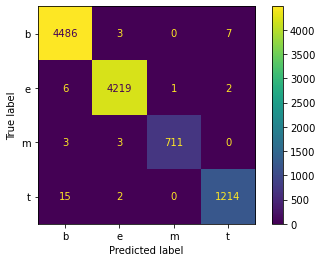

In [20]:
plot_confusion_matrix(clf, tr, training.category) 

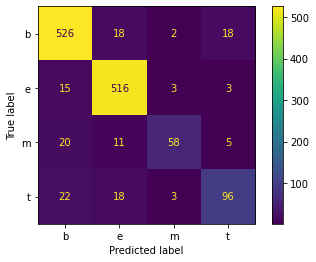

In [21]:
plot_confusion_matrix(clf, te, test.category) 

# Precision, Recall, and F1 Score

* https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [75]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [76]:
labels = ['b', 'e', 'm', 't']

In [80]:
for label in labels:
    idx = test.category == label
    _true = test.category[idx] == label
    _true = _true.astype(int)
    _pred = te_pred[idx] == label
    _pred = _pred.astype(int)
    pr = precision_score(_true, _pred)
    re = recall_score(_true, _pred)
    f1 = f1_score(_true, _pred)
    out = "{}, pr: {:.2f}, re: {:.2f}, f1: {:.2f}".format(label, pr, re, f1)
    print(out)

b, pr: 1.00, re: 0.93, f1: 0.97
e, pr: 1.00, re: 0.96, f1: 0.98
m, pr: 1.00, re: 0.62, f1: 0.76
t, pr: 1.00, re: 0.69, f1: 0.82


In [85]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
micro_f1 = f1_score(test.category, te_pred, average='micro')
micro_pr = precision_score(test.category, te_pred, average='micro')
micro_re = recall_score(test.category, te_pred, average='micro')
out = "Micro-average. pr: {:.2f}, re: {:.2f}, f1: {:.2f}".format(micro_pr, micro_re, micro_f1)
print(out)

macro_f1 = f1_score(test.category, te_pred, average='macro')
macro_pr = precision_score(test.category, te_pred, average='macro')
macro_re = recall_score(test.category, te_pred, average='macro')
out = "Macro-average. pr: {:.2f}, re: {:.2f}, f1: {:.2f}".format(macro_pr, macro_re, macro_f1)
print(out)

Micro-average. pr: 0.90, re: 0.90, f1: 0.90
Macro-average. pr: 0.87, re: 0.80, f1: 0.83


# Feature Weights

* https://stackoverflow.com/a/51465357/684592

In [87]:
clf.coef_

array([[ 0.19489133,  0.00448646,  0.00348532, ..., -0.05603126,
        -0.05193079, -0.00150825],
       [-0.10559604, -0.00210336, -0.00077609, ...,  0.11513483,
         0.09266552,  0.00578923],
       [-0.04752614, -0.00158014, -0.00072162, ..., -0.01737215,
        -0.02380647, -0.00129844],
       [-0.04176915, -0.00080295, -0.00198761, ..., -0.04173142,
        -0.01692826, -0.00298254]])

In [135]:
abs_weights = np.abs(clf.coef_)
weights_0 = abs_weights[0]

In [136]:
# For the first class
sorted_index_0 = np.argsort(weights_0)[::-1]

In [137]:
feature_names = np.array(feature_names)
print(feature_names[sorted_index_0[:10]])
print(weights_0[:10])

['bank' 'fed' 'ukraine' 'ecb' 'china' 'dollar' 'profit' 'obamacare'
 'yellen' 'stocks']
[0.19489133 0.00448646 0.00348532 0.06534941 0.22132312 0.03723387
 0.01367796 0.04995409 0.0283783  0.0032133 ]


# Regularization

* L1, L2, Elastic, and None. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn-linear-model-logisticregression

In [139]:
clf_none = LogisticRegression(penalty='none', random_state=0).fit(tr, training.category)
clf_l1 = LogisticRegression(penalty='none', random_state=0).fit(tr, training.category)
clf_l2 = LogisticRegression(penalty='none', random_state=0).fit(tr, training.category)
clf_elasticnet = LogisticRegression(penalty='elasticnet', random_state=0, l1_ratio=0.5, solver='saga').fit(tr, training.category)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [140]:
te_pred_none = clf_none.predict(te)
te_pred_l1 = clf_l1.predict(te)
te_pred_l2 = clf_l2.predict(te)
te_pred_elasticnet = clf_elasticnet.predict(te)

In [145]:
te_acc_none = accuracy_score(test.category, te_pred_none)
te_acc_l1 = accuracy_score(test.category, te_pred_l1)
te_acc_l2 = accuracy_score(test.category, te_pred_l2)
te_acc_elasticnet = accuracy_score(test.category, te_pred_elasticnet)

In [148]:
out = "Accuracy: none: {:.2f}, l1: {:.2f}, l2: {:.2f}, elasticnet: {:.2f}".format(
    te_acc_none, 
    te_acc_l1, 
    te_acc_l2, 
    te_acc_elasticnet)
print(out)

Accuracy: none: 0.89, l1: 0.89, l2: 0.89, elasticnet: 0.89


# Hyper-parameter Tuning